In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits

import torch
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split

os.chdir('BayesHI')
import bayeshi

In [2]:
model = bayeshi.load_model('tpcnet_all_phases')

/home/120/em8117/.local/lib/python3.12/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


In [3]:
train_loader, val_loader, test_loader = bayeshi.load_tigress_data(sim_number='300')

Loading data for simulation 300
Removed 0 lines of sight with NaNs
Splitting data into train, validation, and test sets with sizes: train=60%, val=20%, test=20%


In [4]:
if os.path.exists('tpcnet_newPE_training_delete.pth'):
    model.load_weights('tpcnet_newPE_training_delete.pth')
else:
    train_errors, val_errors, *_ = model.fit(train_loader, val_loader, "tpcnet_newPE_training_delete.pth")
    plt.figure(figsize=(10,4))
    plt.plot(train_errors, label='Train')
    plt.plot(val_errors, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.title(f'BayesHI training')
    plt.show()

Loading model from tpcnet_newPE_training_delete.pth
Model loaded successfully


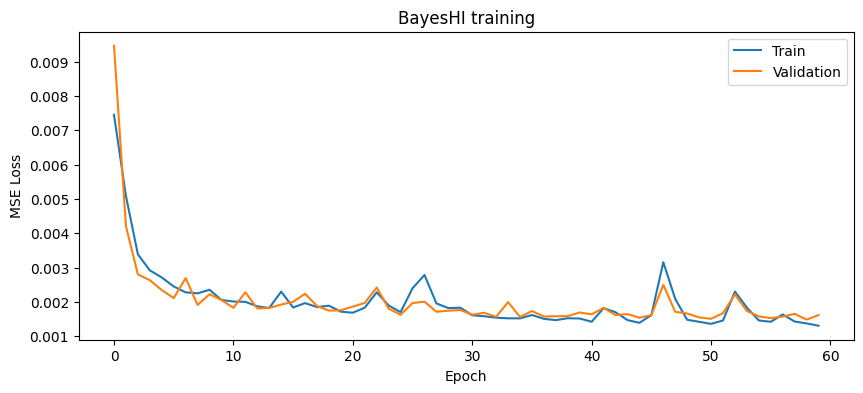

In [10]:
plt.figure(figsize=(10,4))
plt.plot(np.array(train_errors) / 4, label='Train')
plt.plot(val_errors, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.title(f'BayesHI training')
plt.show()

In [5]:
# Predict on test set
predictions = model.predict(test_loader, 1).cpu().numpy()

Predicting: 100%|██████████| 1/1 [00:09<00:00,  9.08s/it]


In [6]:
avg_predictions = predictions[0]

In [7]:
y_test = np.array([x[1] for x in test_loader]).reshape(-1,4)

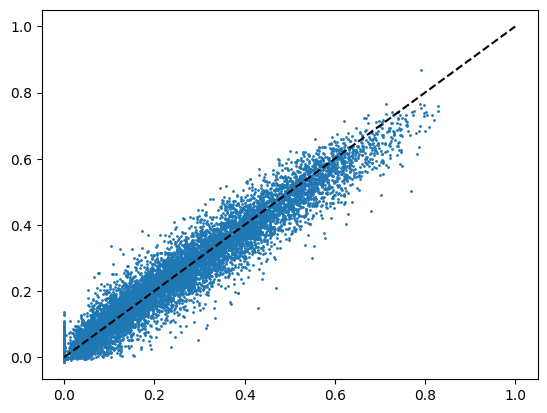

In [8]:
plt.scatter(y_test[:,0], avg_predictions[:,0], s=1)
plt.plot([0,1],[0,1],'k--')

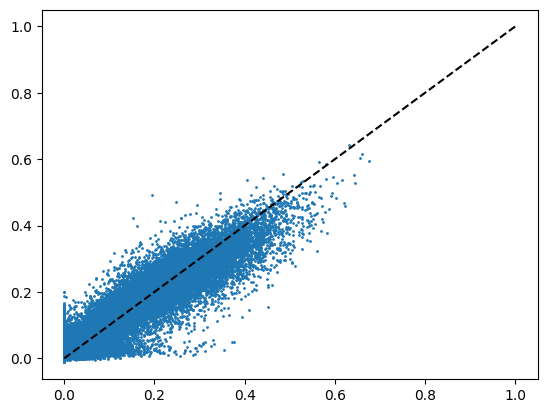

In [9]:
plt.scatter(y_test[:,1], avg_predictions[:,1], s=1)
plt.plot([0,1],[0,1],'k--')

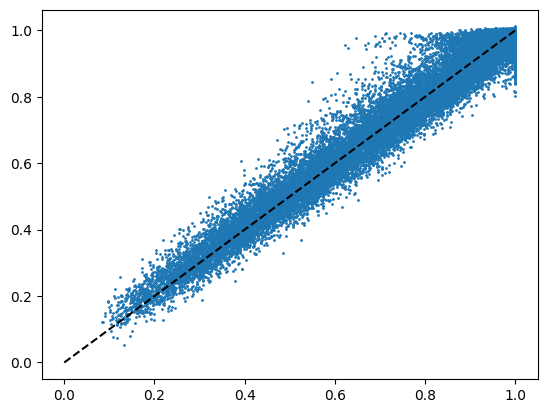

In [10]:
plt.scatter(y_test[:,2], avg_predictions[:,2], s=1)
plt.plot([0,1],[0,1],'k--')

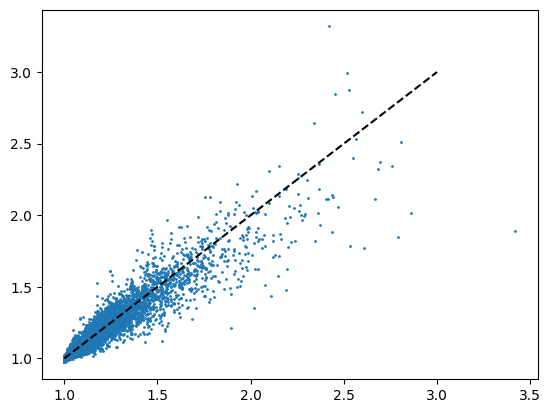

In [11]:
plt.scatter(y_test[:,3], avg_predictions[:,3], s=1)
plt.plot([1,3],[1,3],'k--')

In [60]:
print(model.conv2._parameters['weight'].shape)

torch.Size([64, 72, 1, 33])


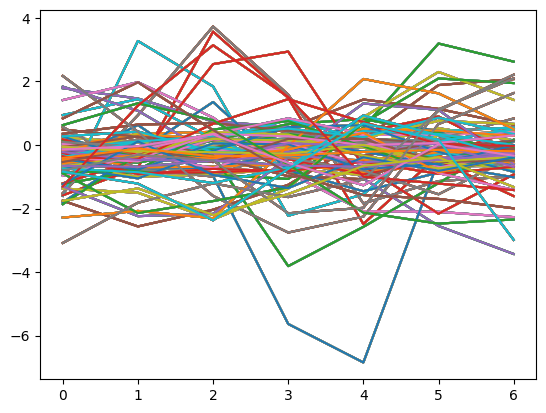

In [67]:
# Plot some of the kernels

for i in range(10):
    plt.plot(model.conv1._parameters['weight'][:,0,0,:].detach().cpu().numpy().T)


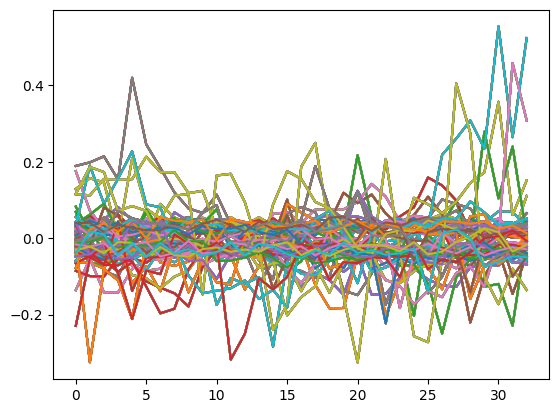

In [68]:
# Plot some of the kernels

for i in range(10):
    plt.plot(model.conv2._parameters['weight'][:,0,0,:].detach().cpu().numpy().T)


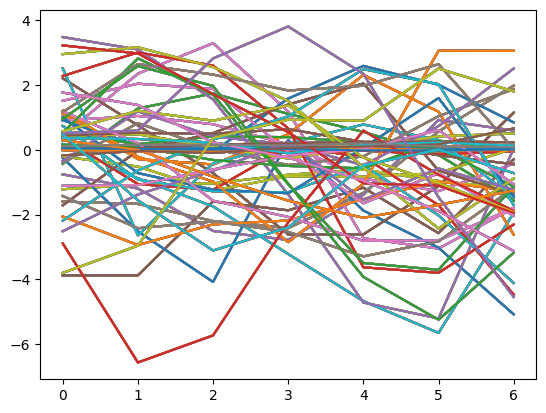

In [69]:
# Plot some of the kernels

for i in range(10):
    plt.plot(model.conv3._parameters['weight'][:,0,0,:].detach().cpu().numpy().T)


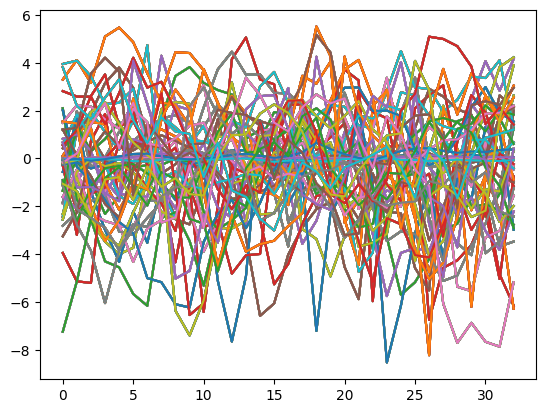

In [70]:
# Plot some of the kernels

for i in range(10):
    plt.plot(model.conv4._parameters['weight'][:,0,0,:].detach().cpu().numpy().T)


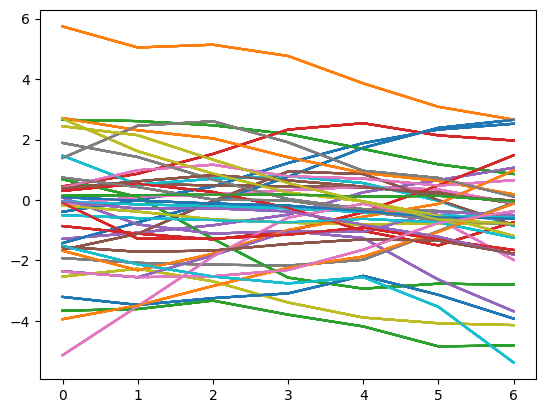

In [71]:
# Plot some of the kernels

for i in range(10):
    plt.plot(model.conv5._parameters['weight'][:,0,0,:].detach().cpu().numpy().T)


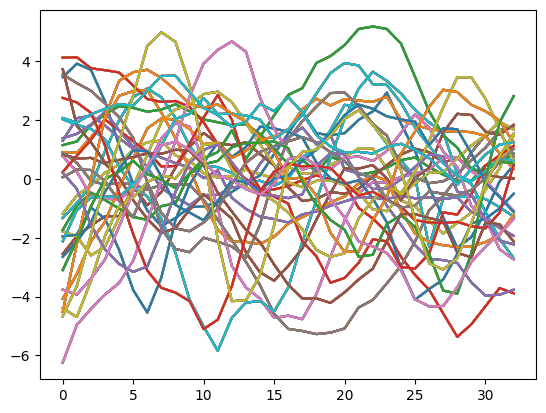

In [72]:
# Plot some of the kernels

for i in range(10):
    plt.plot(model.conv6._parameters['weight'][:,0,0,:].detach().cpu().numpy().T)


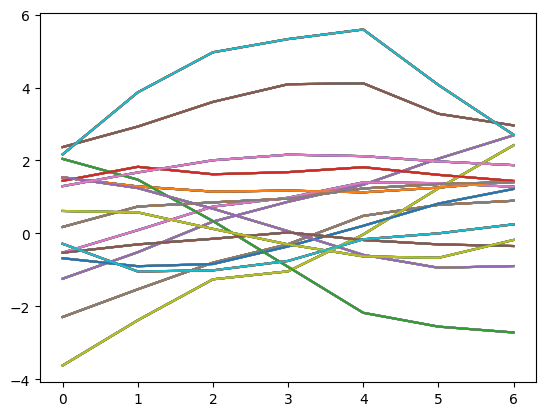

In [73]:
# Plot some of the kernels

for i in range(10):
    plt.plot(model.conv7._parameters['weight'][:,0,0,:].detach().cpu().numpy().T)


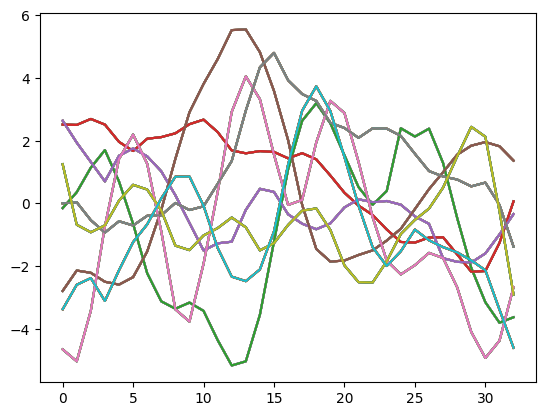

In [74]:
# Plot some of the kernels

for i in range(10):
    plt.plot(model.conv8._parameters['weight'][:,0,0,:].detach().cpu().numpy().T)
